In [ ]:
!nvidia-smi

Sat Aug 29 10:07:36 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P0    29W /  70W |   4711MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
!pip install dipy fury

In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow.keras.layers as layers
import matplotlib.pyplot as plt
import math
        
print(tf.__version__)
print(tf.keras.backend.image_data_format())

2.3.0
channels_last


Loss functions


*   Global Normalized Cross-Correlation (dot product of two normalized images)
*   Local Normalized Cross-Correlation - code taken from https://github.com/voxelmorph/voxelmorph/blob/legacy/src/losses.py#L28
*   Gradient loss (for regularizing the deformations) - code taken from https://github.com/voxelmorph/voxelmorph/blob/legacy/pytorch/losses.py#L13



In [ ]:
def global_normalized_cross_correlation_loss():
    def ncc(y_true, y_pred):
        """Computes the normalized cross-correlation (NCC) loss.

        Parameters
        ----------
        y_true : tf.Tensor
            The static image to which the moving image is aligned.
        y_pred : tf.Tensor
            The moving image, the same shape as the static image.

        Returns
        -------
        loss : tf.Tensor, shape ()
            Normalized cross-correlation loss between the static and the
            moving images, averaged over the batch. Range is [-1.0, 1.0].
            The best value is -1 (perfect match) and the worst is 1.

        References
        ----------
        .. [1] `Wikipedia entry for the Cross-correlation
               <https://en.wikipedia.org/wiki/Cross-correlation>`_

        """
        ndim = tf.keras.backend.ndim(y_true)-2

        # shape (N, 1, 1, C)
        y_true_mean = tf.reduce_mean(y_true, axis=range(1, ndim+1),
                                     keepdims=True)
        y_pred_mean = tf.reduce_mean(y_pred, axis=range(1, ndim+1),
                                     keepdims=True)

        y_true_hat = tf.math.l2_normalize(y_true-y_true_mean,
                                          axis=range(1, ndim+1))

        y_pred_hat = tf.math.l2_normalize(y_pred-y_pred_mean,
                                          axis=range(1, ndim+1))

        return -tf.reduce_mean(tf.reduce_sum(y_true_hat * y_pred_hat,
                                             axis=range(1, ndim+1)))
    return ncc


def local_normalized_cross_correlation_loss(window=(9, 9, 9), eps=1e-5):
    """
    Code borrowed from https://github.com/voxelmorph/voxelmorph/blob/legacy/src/losses.py#L28
    Paper: https://openaccess.thecvf.com/content_cvpr_2018/papers/Balakrishnan_An_Unsupervised_Learning_CVPR_2018_paper.pdf
    """
    def ncc(I, J, window=window):
        # get dimension of volume
        # assumes I, J are sized [batch_size, *vol_shape, nb_feats]
        # ndims = len(I.get_shape().as_list()) - 2
        ndims = tf.keras.backend.ndim(I)-2
        assert ndims in [1, 2, 3], "volumes should be 1 to 3 dimensions. found: %d" % ndims

        # set window size
        if window is None:
            window = [9] * ndims

        # get convolution function
        conv_fn = getattr(tf.nn, 'conv%dd' % ndims)

        # compute CC squares
        I2 = I*I
        J2 = J*J
        IJ = I*J

        # compute filters
        sum_filt = tf.ones([*window, 1, 1])
        strides = 1
        if ndims > 1:
            strides = [1] * (ndims + 2)
        padding = 'SAME'

        # compute local sums via convolution
        I_sum = conv_fn(I, sum_filt, strides, padding)
        J_sum = conv_fn(J, sum_filt, strides, padding)
        I2_sum = conv_fn(I2, sum_filt, strides, padding)
        J2_sum = conv_fn(J2, sum_filt, strides, padding)
        IJ_sum = conv_fn(IJ, sum_filt, strides, padding)

        # compute cross correlation
        win_size = np.prod(window)
        u_I = I_sum/win_size
        u_J = J_sum/win_size

        cross = IJ_sum - u_J*I_sum - u_I*J_sum + u_I*u_J*win_size
        I_var = I2_sum - 2 * u_I * I_sum + u_I*u_I*win_size
        J_var = J2_sum - 2 * u_J * J_sum + u_J*u_J*win_size

        cc = cross*cross / (I_var*J_var + eps)

        # return negative cc.
        return -tf.reduce_mean(cc)
    return ncc


def gradient_loss(norm=2):
    """
    Code borrowed from https://github.com/voxelmorph/voxelmorph/blob/legacy/pytorch/losses.py#L13
    Paper: https://openaccess.thecvf.com/content_cvpr_2018/papers/Balakrishnan_An_Unsupervised_Learning_CVPR_2018_paper.pdf
    """
    def grad_loss(_, phi):
        di = tf.abs(phi[:, 1:, :, :, :] - phi[:, :-1, :, :, :])
        dj = tf.abs(phi[:, :, 1:, :, :] - phi[:, :, :-1, :, :])
        dk = tf.abs(phi[:, :, :, 1:, :] - phi[:, :, :, :-1, :])

        loss = tf.reduce_mean(di) + tf.reduce_mean(dj) + tf.reduce_mean(dk)
        if norm == 2:
            loss = tf.reduce_mean(di**2) + tf.reduce_mean(dj**2) + tf.reduce_mean(dk**2)    
        return loss
    return grad_loss

Functions for differentiable image sampling

References:

1.   https://github.com/tensorflow/models/blob/master/research/transformer/spatial_transformer.py
2.   Jaderberg, Max, Karen Simonyan, and Andrew Zisserman. "Spatial
    transformer networks." Advances in neural information processing
    systems. 2015. https://arxiv.org/pdf/1506.02025.pdf
3.   *Spatial* Transformer Networks by Kushagra Bhatnagar https://link.medium.com/0b2OrmqVO5






In [ ]:
def regular_grid_3d(depth, height, width):
    """Returns a 3-D regular grid.

    Parameters
    ----------
    depth : int
        The desired depth of the grid.
    height : int
        The desired height of the grid.
    width : int
        The desired width of the grid.
    Returns
    -------
    grid : tf.Tensor, shape (D, H, W, 3)
        A 3-D regular grid, values normalized to [-1.0, 1.0]
        range.

    Notes
    -----
    Sampling using the regular grid is an identity transformation, i.e.,
    it results in the same input and output images.

    References
    ----------
    .. [1] `NumPy, "numpy.meshgrid"
        <https://numpy.org/doc/stable/reference/generated/numpy.meshgrid.html>`_
    .. [2] `NumPy, "numpy.indices"
        <https://numpy.org/doc/stable/reference/generated/numpy.indices.html>`_

    """
    i = tf.linspace(-1.0, 1.0, depth)
    j = tf.linspace(-1.0, 1.0, height)
    k = tf.linspace(-1.0, 1.0, width)

    I, J, K = tf.meshgrid(i, j, k, indexing='ij')

    grid = tf.stack([I, J, K], axis=-1)
    return grid


def grid_sample_3d(moving, grid, name=None):
    """Given a moving image and a sampling grid as input, computes the
    transformed image by sampling the moving image at locations given by
    the grid.

    Parameters
    ----------
    moving : tf.Tensor, shape (N, D, H, W, C)
        The moving image.
    grid : tf.Tensor, shape (N, D, H, W, C)
        A tensor of sampling points (x, y, z). The x, y and z values should be
        normalized to [-1.0, 1.0] range.
    name : str
        Name for the operation.

    Returns
    -------
    moved : tf.Tensor, shape (N, D, H, W, C)
        The transformed image.

    Notes
    -----
    Let M be the moving image of shape (H, W, C), T be the transformed
    image of the same shape and G be the 2D sampling grid of shape
    (H, W, 2). The value of T at a location (x, y) is T[y, x, :] =
    M[y', x', :] where [x', y'] = G[y, x, :].

    Further, [x', y'] = [x + dx, y + dy] where [dx, dy] are the
    displacements outputted by the CNN. When dx and dy are 0, the
    sampling grid G is a regular grid and the transformed image is the
    same as the moving image.

    Since the sampling point (x + dx, y + dy) can be non-integral, the
    value M[y', x'] is calculated using bi-linear interpolation.

    References
    ----------
    .. [1] `Jaderberg, Max, Karen Simonyan, and Andrew Zisserman. "Spatial
        transformer networks." Advances in neural information processing
        systems. 2015. <https://arxiv.org/abs/1506.02025>`_
    .. [2] `TensorFlow implementation of spatial transformer networks.
        <https://github.com/tensorflow/models/tree/master/research/transformer>`_
    .. [3] `Spatial Transformer Networks by Kushagra Bhatnagar
        <https://link.medium.com/0b2OrmqVO5>`_

    """
    nb, nd, nh, nw, nc = tf.shape(moving)

    i = grid[..., 0]  # shape (N, D, H, W)
    j = grid[..., 1]
    k = grid[..., 2]
    i = tf.cast(i, 'float32')
    j = tf.cast(j, 'float32')
    k = tf.cast(k, 'float32')

    # Scale i, j and k from [-1.0, 1.0] to [0, D], [0, H] and [0, W] respectively.
    i = (i + 1.0) * 0.5 * tf.cast(nd-1, 'float32')
    j = (j + 1.0) * 0.5 * tf.cast(nh-1, 'float32')
    k = (k + 1.0) * 0.5 * tf.cast(nw-1, 'float32')

    i_max = tf.cast(nd - 1, 'int32')
    j_max = tf.cast(nh - 1, 'int32')
    k_max = tf.cast(nw - 1, 'int32')
    zero = tf.constant(0, 'int32')

    # The value at (i, j, k) is a weighted average of the values at the
    # eight nearest integer locations: (i0, j0, k0), (i0, j0, k1), (i0, j1, k0),
    # (i0, j1, k1), (i1, j0, k0), (i1, j0, k1), (i1, j1, k0) and (i1, j1, k1)
    # where i0 = floor(i), i1 = ceil(i).
    i0 = tf.cast(tf.floor(i), 'int32')
    i1 = i0 + 1
    j0 = tf.cast(tf.floor(j), 'int32')
    j1 = j0 + 1
    k0 = tf.cast(tf.floor(k), 'int32')
    k1 = k0 + 1

    # Make sure indices are within the boundaries of the image.
    i0 = tf.clip_by_value(i0, zero, i_max)
    i1 = tf.clip_by_value(i1, zero, i_max)
    j0 = tf.clip_by_value(j0, zero, j_max)
    j1 = tf.clip_by_value(j1, zero, j_max)
    k0 = tf.clip_by_value(k0, zero, k_max)
    k1 = tf.clip_by_value(k1, zero, k_max)

    # Collect indices of the four corners.
    b = tf.ones_like(i0) * tf.reshape(tf.range(nb), [nb, 1, 1, 1])
    idx_a = tf.stack([b, i1, j0, k0], axis=-1)  # all front-top-left corners
    idx_b = tf.stack([b, i1, j1, k0], axis=-1)  # all front-bottom-left corners
    idx_c = tf.stack([b, i1, j0, k1], axis=-1)  # all front-top-right corners
    idx_d = tf.stack([b, i1, j1, k1], axis=-1)  # all front-bottom-right corners
    idx_e = tf.stack([b, i0, j0, k0], axis=-1)  # all back-top-left corners
    idx_f = tf.stack([b, i0, j1, k0], axis=-1)  # all back-bottom-left corners
    idx_g = tf.stack([b, i0, j0, k1], axis=-1)  # all back-top-right corners
    idx_h = tf.stack([b, i0, j1, k1], axis=-1)  # all back-bottom-right corners
    # shape (N, D, H, W, 3)

    # Collect values at the corners.
    moving_a = tf.gather_nd(moving, idx_a)  # all front-top-left values
    moving_b = tf.gather_nd(moving, idx_b)  # all front-bottom-left values
    moving_c = tf.gather_nd(moving, idx_c)  # all front-top-right values
    moving_d = tf.gather_nd(moving, idx_d)  # all front-bottom-right values
    moving_e = tf.gather_nd(moving, idx_e)  # all back-top-left values
    moving_f = tf.gather_nd(moving, idx_f)  # all back-bottom-left values
    moving_g = tf.gather_nd(moving, idx_g)  # all back-top-right values
    moving_h = tf.gather_nd(moving, idx_h)  # all back-bottom-right values
    # shape (N, D, H, W, C)

    i0_f = tf.cast(i0, 'float32')
    i1_f = tf.cast(i1, 'float32')
    j0_f = tf.cast(j0, 'float32')
    j1_f = tf.cast(j1, 'float32')
    k0_f = tf.cast(k0, 'float32')
    k1_f = tf.cast(k1, 'float32')

    # Calculate the weights.
    wa = tf.expand_dims((i - i0_f) * (j1_f - j) * (k1_f - k), axis=-1)
    wb = tf.expand_dims((i - i0_f) * (j - j0_f) * (k1_f - k), axis=-1)
    wc = tf.expand_dims((i - i0_f) * (j1_f - j) * (k - k0_f), axis=-1)
    wd = tf.expand_dims((i - i0_f) * (j - j0_f) * (k - k0_f), axis=-1)
    we = tf.expand_dims((i1_f - i) * (j1_f - j) * (k1_f - k), axis=-1)
    wf = tf.expand_dims((i1_f - i) * (j - j0_f) * (k1_f - k), axis=-1)
    wg = tf.expand_dims((i1_f - i) * (j1_f - j) * (k - k0_f), axis=-1)
    wh = tf.expand_dims((i1_f - i) * (j - j0_f) * (k - k0_f), axis=-1)

    # Calculate the weighted sum.
    moved = tf.add_n([wa * moving_a, wb * moving_b, wc * moving_c,
                      wd * moving_d, we * moving_e, wf * moving_f,
                      wg * moving_g, wh * moving_h], name=name)
    return moved

VoxelMorph-1 model

In [ ]:
class VoxelMorph1(object):
    def __init__(self, input_shape=(32, 32, 1), optimizer='adam', loss=None,
                 metrics=None, loss_weights=None):
        in_channels = 1
        out_channels = 3
        input_shape = input_shape + (in_channels,)

        moving = layers.Input(shape=input_shape, name='moving')
        static = layers.Input(shape=input_shape, name='static')

        x_in = layers.concatenate([static, moving], axis=-1)

        # encoder
        x1 = layers.Conv3D(16, kernel_size=3, strides=2, padding='same',
                           kernel_initializer='he_normal')(x_in)
        x1 = layers.LeakyReLU(alpha=0.2)(x1)  # 16

        x2 = layers.Conv3D(32, kernel_size=3, strides=2, padding='same',
                           kernel_initializer='he_normal')(x1)
        x2 = layers.LeakyReLU(alpha=0.2)(x2)  # 8

        x3 = layers.Conv3D(32, kernel_size=3, strides=2, padding='same',
                           kernel_initializer='he_normal')(x2)
        x3 = layers.LeakyReLU(alpha=0.2)(x3)  # 4

        x4 = layers.Conv3D(32, kernel_size=3, strides=2, padding='same',
                           kernel_initializer='he_normal')(x3)
        x4 = layers.LeakyReLU(alpha=0.2)(x4)  # 2

        # decoder [32, 32, 32, 32, 8, 8]
        x = layers.Conv3D(32, kernel_size=3, strides=1, padding='same',
                          kernel_initializer='he_normal')(x4)
        x = layers.LeakyReLU(alpha=0.2)(x)
        x = layers.UpSampling3D(size=2)(x)  # 4
        x = layers.concatenate([x, x3], axis=-1)  # 4

        x = layers.Conv3D(32, kernel_size=3, strides=1, padding='same',
                          kernel_initializer='he_normal')(x)
        x = layers.LeakyReLU(alpha=0.2)(x)
        x = layers.UpSampling3D(size=2)(x)  # 8
        x = layers.concatenate([x, x2], axis=-1)  # 8

        x = layers.Conv3D(32, kernel_size=3, strides=1, padding='same',
                          kernel_initializer='he_normal')(x)
        x = layers.LeakyReLU(alpha=0.2)(x)
        x = layers.UpSampling3D(size=2)(x)  # 16
        x = layers.concatenate([x, x1], axis=-1)  # 16

        x = layers.Conv3D(32, kernel_size=3, strides=1, padding='same',
                          kernel_initializer='he_normal')(x)
        x = layers.LeakyReLU(alpha=0.2)(x)

        x = layers.Conv3D(8, kernel_size=3, strides=1, padding='same',
                          kernel_initializer='he_normal')(x)
        x = layers.LeakyReLU(alpha=0.2)(x)  # 16

        x = layers.UpSampling3D(size=2)(x)  # 32
        x = layers.concatenate([x, x_in], axis=-1)
        x = layers.Conv3D(8, kernel_size=3, strides=1, padding='same',
                          kernel_initializer='he_normal')(x)
        x = layers.LeakyReLU(alpha=0.2)(x)  # 32

        kernel_initializer = tf.keras.initializers.RandomNormal(mean=0.0,
                                                                stddev=1e-5)
        deformation = layers.Conv3D(out_channels, kernel_size=3, strides=1,
                                    padding='same',
                                    kernel_initializer=kernel_initializer,
                                    name='deformation')(x)

        nb, nd, nh, nw, nc = tf.shape(deformation)

        # Regular grid.
        grid = regular_grid_3d(nd, nh, nw)  # shape (D, H, W, 2)
        grid = tf.expand_dims(grid, axis=0)  # shape (1, D, H, W, 2)
        multiples = tf.stack([nb, 1, 1, 1, 1])
        grid = tf.tile(grid, multiples)

        # Compute the new sampling grid.
        grid_new = grid + deformation
        grid_new = tf.clip_by_value(grid_new, -1, 1)

        # Sample the moving image using the new sampling grid.
        moved = grid_sample_3d(moving, grid_new, name='moved')

        model = tf.keras.Model(inputs={'moving': moving, 'static': static},
                               outputs={'moved': moved, 'deformation': deformation}, name='voxelmorph1')
        model.compile(optimizer=optimizer, loss=loss, metrics=metrics,
                      loss_weights=loss_weights)
        
        self.model = model

    def compile(self, optimizer='adam', loss=None, metrics=None,
                loss_weights=None):
        self.model.compile(optimizer=optimizer, loss=loss, metrics=metrics,
                           loss_weights=loss_weights)

    def summary(self):
        return self.model.summary()

    def fit(self, x=None, y=None, batch_size=None, epochs=1, verbose=1,
            callbacks=None, validation_split=0.0, validation_data=None,
            shuffle=True, initial_epoch=0, steps_per_epoch=None,
            validation_steps=None, validation_batch_size=None,
            validation_freq=1, max_queue_size=10, workers=1,
            use_multiprocessing=False):
        return self.model.fit(x=x, y=y, batch_size=batch_size,
                              epochs=epochs, verbose=verbose,
                              callbacks=callbacks,
                              validation_split=validation_split,
                              validation_data=validation_data, shuffle=shuffle,
                              initial_epoch=initial_epoch,
                              steps_per_epoch=steps_per_epoch,
                              validation_steps=validation_steps,
                              validation_batch_size=validation_batch_size,
                              validation_freq=validation_freq,
                              max_queue_size=max_queue_size, workers=workers,
                              use_multiprocessing=use_multiprocessing)

    def evaluate(self, x=None, y=None, batch_size=None, verbose=1,
                 steps=None, callbacks=None, max_queue_size=10, workers=1,
                 use_multiprocessing=False, return_dict=False):
        return self.model.evaluate(x=x, y=y, batch_size=batch_size,
                                   verbose=verbose, steps=steps,
                                   callbacks=callbacks,
                                   max_queue_size=max_queue_size,
                                   workers=workers,
                                   use_multiprocessing=use_multiprocessing,
                                   return_dict=return_dict)

    def predict(self, x, batch_size=None, verbose=0,
                steps=None, callbacks=None, max_queue_size=10, workers=1,
                use_multiprocessing=False):
        return self.model.predict(x=x, batch_size=batch_size,
                                  verbose=verbose, steps=steps,
                                  callbacks=callbacks,
                                  max_queue_size=max_queue_size,
                                  workers=workers,
                                  use_multiprocessing=use_multiprocessing)

    def save_weights(self, filepath, overwrite=True):
        self.model.save_weights(filepath=filepath, overwrite=overwrite,
                                save_format=None)

    def load_weights(self, filepath):
        self.model.load_weights(filepath)

Data loader

In [ ]:
class RegistrationDataLoader(tf.keras.utils.Sequence):
    def __init__(self, moving, static, batch_size=8, shuffle=False):
        """Data loader object that fetches and preprocess batches of images 
        for real-time data feeding to the model.

        Currently supports only numpy arrays as input.
    
        Parameters
        ----------
        moving : ndarray, shape (N, ..., C)
            An array of all the moving images. N is the number of images.
        static : ndarray, shape (1, ..., C)
            The static image.

        """
        self.moving = moving
        self.static = static
        self.batch_size = batch_size
        self.shuffle = shuffle

        if self.shuffle:
            np.random.shuffle(self.moving)

    def __len__(self):
        return math.ceil(len(self.moving) / self.batch_size)

    def __getitem__(self, idx):
        moving = self.moving[idx * self.batch_size: (idx+1) * self.batch_size]
        static = np.repeat(self.static, repeats=moving.shape[0], axis=0)

        return {'moving': moving, 'static': static}, static  # input and output

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.moving)

Hyperparameters used for training the network

In [ ]:
batch_size = 1
epochs = 60
lr = 0.001  # learning rate
lamda = 1.0  # (lambda) regularization parameter
input_shape = (128, 128, 128)

Fetch and preprocess data

In [ ]:
data = np.load('drive/My Drive/DIPY/brain_affine_128.npy')
static = np.load('drive/My Drive/DIPY/static.npy')

x_train = data[:125, ...][..., None]
x_train = x_train.astype(np.float32)/255.0
x_test = data[125:-1, ...][..., None]
x_test = x_test.astype(np.float32)/255.0
x_sample = x_test[:5, ...].copy()  # some images to visualize results

static = static[None, ..., None]
static = static.astype(np.float32)/255.0

print('Train: ', x_train.shape)
print('Test: ', x_test.shape)
print('Sample: ', x_sample.shape)
print('Static: ', static.shape)

# Create the data loader objects
train_loader = RegistrationDataLoader(x_train, static, batch_size=batch_size,
                                      shuffle=True)
test_loader = RegistrationDataLoader(x_test, static, batch_size=batch_size,
                                     shuffle=True)
sample_loader = RegistrationDataLoader(x_sample, static, shuffle=True)

Train:  (125, 128, 128, 128, 1)
Test:  (29, 128, 128, 128, 1)
Sample:  (5, 128, 128, 128, 1)
Static:  (1, 128, 128, 128, 1)


Instantiate and compile the model with the loss and the optimizer.

In [ ]:
ncc_loss = local_normalized_cross_correlation_loss()
grad_loss = gradient_loss()

# Map model outputs to the loss functions and loss weights
loss_weights = {'moved': 1.0, 'deformation': lamda}
losses = {'moved': ncc_loss, 'deformation': grad_loss}

optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

model = VoxelMorph1(input_shape=input_shape, optimizer=optimizer,
                    loss=losses, loss_weights=loss_weights)

Training

In [ ]:
hist = model.fit(train_loader, epochs=epochs, validation_data=test_loader)

Epoch 1/60
125/125 [==============================] - 132s 1s/step - loss: -0.0764 - deformation_loss: 8.6801e-06 - tf_op_layer_moved_1_loss: -0.0765 - val_loss: -0.0868 - val_deformation_loss: 1.4855e-05 - val_tf_op_layer_moved_1_loss: -0.0868
Epoch 2/60
125/125 [==============================] - 131s 1s/step - loss: -0.0903 - deformation_loss: 1.7532e-05 - tf_op_layer_moved_1_loss: -0.0903 - val_loss: -0.0918 - val_deformation_loss: 2.0148e-05 - val_tf_op_layer_moved_1_loss: -0.0918
Epoch 3/60
125/125 [==============================] - 131s 1s/step - loss: -0.0944 - deformation_loss: 2.2750e-05 - tf_op_layer_moved_1_loss: -0.0944 - val_loss: -0.0945 - val_deformation_loss: 2.3132e-05 - val_tf_op_layer_moved_1_loss: -0.0946
Epoch 4/60
125/125 [==============================] - 131s 1s/step - loss: -0.0967 - deformation_loss: 2.6395e-05 - tf_op_layer_moved_1_loss: -0.0967 - val_loss: -0.0976 - val_deformation_loss: 2.8746e-05 - val_tf_op_layer_moved_1_loss: -0.0976
Epoch 5/60
125/125 [

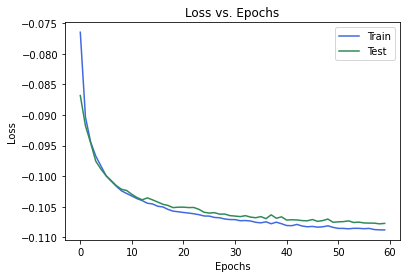

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(hist.history['loss'], color='royalblue', label='Train')
plt.plot(hist.history['val_loss'], color='seagreen', label='Test')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="upper right")
plt.title('Loss vs. Epochs')
plt.show()
plt.savefig('loss_plot.png')

Compute the moved images for the sample set

In [ ]:
output = model.predict(sample_loader)
moved = output['moved']
deformation = output['deformation']

Visualize the transformed image together with the static and the moving images.

In [ ]:
# Some helper functions to visualize the results
def _tile_plot(imgs, titles, **kwargs):
    """
    Helper function
    """
    # Create a new figure and plot the three images
    fig, ax = plt.subplots(3, len(imgs[0]), gridspec_kw={'wspace': 0.11, 'hspace': -0.3})
    plt.subplots_adjust(wspace=0, hspace=0)

    for i in range(3):
        for ii, a in enumerate(ax[i]):
            a.set_axis_off()
            a.imshow(imgs[i][ii], interpolation='bilinear', **kwargs)
            if i == 0:
                a.set_title(titles[ii], fontsize=8)
    return fig


def overlay_slices(moving, static, moved, slice_index=None,
                   ltitle='Left', mtitle='Middle', rtitle='Right', fname=None):
    r"""Plot overlaid slices from the given volumes.
    Edited version of dipy.viz.regtools.overlay_slices
    """
    images = []

    sh = static.shape
    moving = np.asarray(moving, dtype=np.float64)
    moving = 255 * (moving - moving.min()) / (moving.max() - moving.min())
    moved = np.asarray(moved, dtype=np.float64)
    moved = 255 * (moved - moved.min()) / (moved.max() - moved.min())
    static = np.asarray(static, dtype=np.float64)
    static = 255 * (static - static.min()) / (static.max() - static.min())

    # Create the color image to draw the overlapped slices into, and extract
    # the slices (note the transpositions)
    if slice_index is None:
        slice_index = sh[0] // 2
    colorll = np.zeros(shape=(sh[2], sh[1], 3), dtype=np.uint8)
    colorrr = np.zeros(shape=(sh[2], sh[1], 3), dtype=np.uint8)
    ll = np.asarray(moving[slice_index, :, :]).astype(np.uint8).T
    rr = np.asarray(moved[slice_index, :, :]).astype(np.uint8).T
    mm = np.asarray(static[slice_index, :, :]).astype(np.uint8).T

    colorll[..., 0] = ll * (ll > ll[0, 0])
    colorll[..., 1] = mm * (mm > mm[0, 0])

    colorrr[..., 0] = rr * (rr > rr[0, 0])
    colorrr[..., 1] = mm * (mm > mm[0, 0])

    images.append([ll, colorll, mm, colorrr, rr])

    if slice_index is None:
        slice_index = sh[1] // 2
    colorll = np.zeros(shape=(sh[2], sh[1], 3), dtype=np.uint8)
    colorrr = np.zeros(shape=(sh[2], sh[1], 3), dtype=np.uint8)
    ll = np.asarray(moving[:, slice_index, :]).astype(np.uint8).T
    rr = np.asarray(moved[:, slice_index, :]).astype(np.uint8).T
    mm = np.asarray(static[:, slice_index, :]).astype(np.uint8).T

    colorll[..., 0] = ll * (ll > ll[0, 0])
    colorll[..., 1] = mm * (mm > mm[0, 0])

    colorrr[..., 0] = rr * (rr > rr[0, 0])
    colorrr[..., 1] = mm * (mm > mm[0, 0])

    images.append([ll, colorll, mm, colorrr, rr])

    if slice_index is None:
        slice_index = sh[2] // 2
    colorll = np.zeros(shape=(sh[2], sh[1], 3), dtype=np.uint8)
    colorrr = np.zeros(shape=(sh[2], sh[1], 3), dtype=np.uint8)
    ll = np.asarray(moving[:, :, slice_index]).astype(np.uint8).T
    rr = np.asarray(moved[:, :, slice_index]).astype(np.uint8).T
    mm = np.asarray(static[:, :, slice_index]).astype(np.uint8).T

    colorll[..., 0] = ll * (ll > ll[0, 0])
    colorll[..., 1] = mm * (mm > mm[0, 0])

    colorrr[..., 0] = rr * (rr > rr[0, 0])
    colorrr[..., 1] = mm * (mm > mm[0, 0])

    images.append([ll, colorll, mm, colorrr, rr])

    fig = _tile_plot(images,
                     [ltitle, 'Overlay', mtitle, 'Overlay', rtitle],
                     cmap=plt.cm.gray, origin='lower')

    if fname is not None:
        fig.savefig(fname, bbox_inches='tight', dpi=200)

    return fig

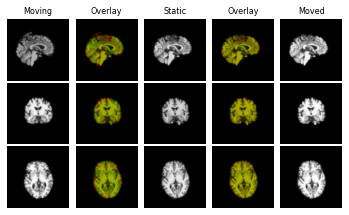

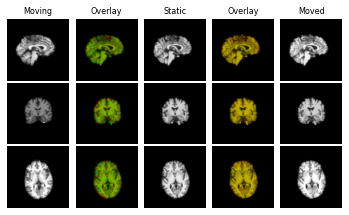

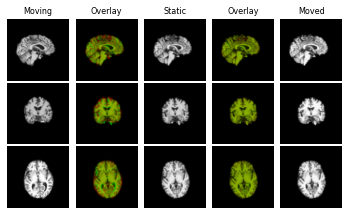

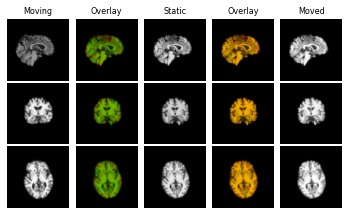

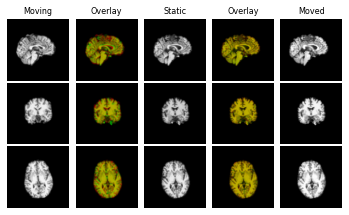

In [ ]:
moved = moved.squeeze(axis=-1)  # Remove the channel dim.
moved = moved * 255.0  # Rescale to [0, 255].
moved = moved.astype(np.uint8)  # Convert back to 8-bit images.

moving = x_sample.copy().squeeze(axis=-1)  # shape (num_samples, 32, 32)
moving = moving * 255.0
moving = moving.astype(np.uint8)

static_ = static.squeeze(axis=-1)  # shape (1, 32, 32)
static_ = np.repeat(static_, repeats=moving.shape[0], axis=0)
static_ = static_*255.0
static_ = static_.astype(np.uint8)

# The images are flipped, so flipping them to the usual style
moving = moving.transpose(0, 1, 3, 2)
moving = np.flip(moving, (1, 3))
moved = moved.transpose(0, 1, 3, 2)
moved = np.flip(moved, (1, 3))
static_ = static_.transpose(0, 1, 3, 2)
static_ = np.flip(static_, (1, 3))

# Plot images.
for i in range(moving.shape[0]):
    overlay_slices(moving[i], static_[i], moved[i], None,
                   'Moving', "Static", "Moved", "%d.png" % (i))

References:


*   Balakrishnan, G., Zhao, A., Sabuncu, M.R., Guttag, J. and Dalca, A.V., 2018. An unsupervised learning model for deformable medical image registration. In Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 9252-9260).
*   Jaderberg, M., Simonyan, K. and Zisserman, A., 2015. Spatial transformer networks. In Advances in neural information processing systems (pp. 2017-2025).
*   TensorFlow implementation of spatial transformer networks. https://github.com/tensorflow/models/tree/master/research/transformer
*   Spatial Transformer Networks by Kushagra Bhatnagar. https://link.medium.com/0b2OrmqVO5

